# **Intersection analysis**

This notebook contains the code to identify genes shared among the **Xenium panel**, the differentially expressed genes in **FA‑HNSCC tumors**, and the differentially expressed genes in **non‑FA HNSCC tumors**. Venn diagrams are not ideal for comparing more than three sets, so this notebook uses an UpSet plot instead.

In [ ]:
# Libraries to import

import pandas as pd
from upsetplot import UpSet, from_contents
import matplotlib.pyplot as plt
import os
from functools import reduce
import operator

In [4]:
# Show files in the current directory
os.listdir()

['FA_SCC_filtered_down_genes.csv',
 'FA_SCC_filtered_up_genes.csv',
 'intersection_hubs.ipynb',
 'Xenium_hBrain_v1_metadata.csv',
 'Xenium_hBreast_v1_metadata.csv',
 'Xenium_hColon_v1_metadata.csv',
 'Xenium_hIO_v1_metadata.csv',
 'Xenium_hLung_v1_metadata.csv',
 'Xenium_hMulti_v1_metadata_annotations.csv',
 'Xenium_hSkin_v1_metadata.csv']

In [6]:
# Load all data sets
df_fahnscc = pd.read_csv("FA_SCC_filtered_up_genes.csv")
df_nonfahnscc = pd.read_csv("FA_SCC_filtered_down_genes.csv")
df_xenium_multi = pd.read_csv("Xenium_hMulti_v1_metadata_annotations.csv")
df_xenium_immunoncology = pd.read_csv("Xenium_hIO_v1_metadata.csv")
df_xenium_brain = pd.read_csv("Xenium_hBrain_v1_metadata.csv")
df_xenium_breast =pd.read_csv("Xenium_hBreast_v1_metadata.csv")
df_xenium_colon = pd.read_csv("Xenium_hColon_v1_metadata.csv")
df_xenium_lung = pd.read_csv("Xenium_hLung_v1_metadata.csv")
df_xenium_skin = pd.read_csv("Xenium_hSkin_v1_metadata.csv")

In [8]:
# Show colnames for each dataframe
print("FA-HNSCC columns:", df_fahnscc.columns)
print("Non-FA HNSCC columns:", df_nonfahnscc.columns)
print("Xenium Multi columns:", df_xenium_multi.columns)
print("Xenium Immuno-Oncology columns:", df_xenium_immunoncology.columns)
print("Xenium Brain columns:", df_xenium_brain.columns)
print("Xenium Breast columns:", df_xenium_breast.columns)
print("Xenium Colon columns:", df_xenium_colon.columns)
print("Xenium Lung columns:", df_xenium_lung.columns)
print("Xenium Skin columns:", df_xenium_skin.columns)


FA-HNSCC columns: Index(['gene_id', 'gene_symbol', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat',
       'pvalue', 'padj'],
      dtype='object')
Non-FA HNSCC columns: Index(['gene_id', 'gene_symbol', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat',
       'pvalue', 'padj'],
      dtype='object')
Xenium Multi columns: Index(['Gene', 'Ensembl ID', 'Probe sets', 'Codewords', 'Tissues',
       'Cell types'],
      dtype='object')
Xenium Immuno-Oncology columns: Index(['Gene', 'Ensemble ID', 'Num_Probesets', 'Codewords', 'Annotation'], dtype='object')
Xenium Brain columns: Index(['Genes', 'Ensembl_ID', 'Num_Probesets', 'Codewords', 'Annotation'], dtype='object')
Xenium Breast columns: Index(['Genes', 'Ensembl_ID', 'Num_Probesets', 'Codewords', 'Annotation'], dtype='object')
Xenium Colon columns: Index(['Gene', 'Ensembl ID', 'Num_Probesets', 'Codewords', 'Annotation'], dtype='object')
Xenium Lung columns: Index(['Gene', 'Ensembl_ID', 'Num_Probesets', 'Codewords', 'Annotation'], dtype='object'

In [9]:
# Make a list of gene sets

genes_fahnscc = df_fahnscc['gene_symbol'].tolist()
genes_nonfahnscc = df_nonfahnscc['gene_symbol'].tolist()
genes_xenium_multi = df_xenium_multi['Gene'].tolist()
genes_xenium_immunoncology = df_xenium_immunoncology['Gene'].tolist()
genes_xenium_brain = df_xenium_brain['Genes'].tolist()
genes_xenium_breast = df_xenium_breast['Genes'].tolist()
genes_xenium_colon = df_xenium_colon['Gene'].tolist()
genes_xenium_lung = df_xenium_lung['Gene'].tolist()
genes_xenium_skin = df_xenium_skin['Gene'].tolist()

In [10]:
# Show number of genes in each set
print("Number of FA-HNSCC genes:", len(genes_fahnscc))
print("Number of Non-FA HNSCC genes:", len(genes_nonfahnscc))
print("Number of Xenium Multi genes:", len(genes_xenium_multi))
print("Number of Xenium Immuno-Oncology genes:", len(genes_xenium_immunoncology))
print("Number of Xenium Brain genes:", len(genes_xenium_brain))
print("Number of Xenium Breast genes:", len(genes_xenium_breast))
print("Number of Xenium Colon genes:", len(genes_xenium_colon))
print("Number of Xenium Lung genes:", len(genes_xenium_lung))
print("Number of Xenium Skin genes:", len(genes_xenium_skin))

Number of FA-HNSCC genes: 3865
Number of Non-FA HNSCC genes: 4399
Number of Xenium Multi genes: 377
Number of Xenium Immuno-Oncology genes: 380
Number of Xenium Brain genes: 266
Number of Xenium Breast genes: 280
Number of Xenium Colon genes: 322
Number of Xenium Lung genes: 289
Number of Xenium Skin genes: 260


In [11]:
# Antibody list
genes_ab = [
    "ITGB3", "MMP1", "MMP2", "MMP7", "MMP8", "MMP11", "MMP13", "MMP14",
    "MMP17", "MMP19", "MMP28", "TIMP3", "COL1A1", "FN1"
]

print(len(genes_ab))  # 14 genes

14


In [12]:
# Protein list 
proteins = [
    "TIMP1","COL1A1","FAP1","FN1","VIM","COL4A1","MMP9","PANCK","TNC","ACTA2"
]
print(len(proteins))  # 10 proteins

10


In [77]:
# Clean data frames

def clean_genes(seq):
    s = pd.Series(seq)
    s = s.dropna()                    # quita NaN/None
    s = s.astype(str).str.strip()     # convierte a str y quita espacios
    s = s[s != '']                    # quita strings vacíos
    s = s[~s.str.lower().isin(['nan','none'])]  # por si hay la cadena 'nan' o 'none'
    return set(s)

genes_fahnscc = clean_genes(genes_fahnscc)
genes_nonfahnscc = clean_genes(genes_nonfahnscc)

shared_genes = genes_fahnscc & genes_nonfahnscc
print("Shared genes (cleaned):", shared_genes)

Shared genes (cleaned): set()


In [78]:
# Make list to contains 
set1 = set(genes_fahnscc)
set2 = set(genes_nonfahnscc)
set3 = set(genes_xenium_multi)
set4 = set(genes_xenium_immunoncology)
set5 = set(genes_xenium_brain)
set6 = set(genes_xenium_breast)
set7 = set(genes_xenium_colon)
set8 = set(genes_xenium_lung)
set9 = set(genes_xenium_skin)
set10 = set(genes_ab)
set11 = set(proteins)

In [79]:
# Show intersections between FA-HNSCC and Xenium panesls plus Antibody and protein lists
print("Intersection between FA-HNSCC and Xenium Multi:", {len(set1.intersection(set3))}, ";", set1.intersection(set3))
print("Intersection between FA-HNSCC and Xenium Immuno-Oncology:", {len(set1.intersection(set4))}, ";", set1.intersection(set4))
print("Intersection between FA-HNSCC and Xenium Brain:", {len(set1.intersection(set5))}, ";", set1.intersection(set5))
print("Intersection between FA-HNSCC and Xenium Breast:", {len(set1.intersection(set6))}, ";", set1.intersection(set6))
print("Intersection between FA-HNSCC and Xenium Colon:", {len(set1.intersection(set7))}, ";", set1.intersection(set7))
print("Intersection between FA-HNSCC and Xenium Lung:", {len(set1.intersection(set8))}, ";", set1.intersection(set8))
print("Intersection between FA-HNSCC and Xenium Skin:", {len(set1.intersection(set9))}, ";", set1.intersection(set9))
print("Intersection between FA-HNSCC and Antibody list:", {len(set1.intersection(set10))}, ";", set1.intersection(set10))
print("Intersection between FA-HNSCC and Protein list:", {len(set1.intersection(set11))}, ";", set1.intersection(set11))

Intersection between FA-HNSCC and Xenium Multi: {39} ; {'IGF1', 'CYP3A4', 'IL7R', 'MLANA', 'CXCL2', 'EGFR', 'OGN', 'SLC18A2', 'TIMP4', 'MKI67', 'KLRD1', 'CAPN8', 'SLC26A2', 'STC2', 'LYVE1', 'FAS', 'TFPI', 'TM4SF4', 'TMEM100', 'CD274', 'CCDC39', 'ARFGEF3', 'CSF3', 'CD300E', 'TMC5', 'MET', 'PPARG', 'MDM2', 'ASPN', 'PROX1', 'NTN4', 'COL5A2', 'GLIPR1', 'FBN1', 'VCAN', 'CDK1', 'TOP2A', 'DST', 'CENPF'}
Intersection between FA-HNSCC and Xenium Immuno-Oncology: {39} ; {'IL7R', 'FGF2', 'ITGA1', 'IFIT2', 'NT5E', 'VEGFA', 'EGFR', 'CXCL2', 'MKI67', 'KLRD1', 'CDK12', 'IL1B', 'FAS', 'HIF1A', 'KMT2C', 'NOTCH2', 'CEACAM8', 'PTEN', 'CD274', 'MIS18BP1', 'BRAF', 'ATM', 'KRAS', 'CCL16', 'MET', 'IL10', 'IL1R1', 'ORC6', 'MGP', 'IL1A', 'AREG', 'CXCL3', 'CDK6', 'IL13RA2', 'PIK3CA', 'NF1', 'VCAN', 'CDK1', 'CENPF'}
Intersection between FA-HNSCC and Xenium Brain: {35} ; {'IL7R', 'EGFR', 'THBS1', 'PTCHD4', 'COL12A1', 'MKI67', 'CEMIP2', 'LYVE1', 'NTNG1', 'ABCC9', 'TRPC6', 'GAS2L3', 'C1QL3', 'TGFB2', 'SLC26A4', 'PC

In [105]:
# Save intersections based on FA-HNSCC versus all other sets defined in 'sets'

# Use the 'sets' dictionary if it exists in the notebook
all_sets = sets if 'sets' in globals() else {
    'FA-HNSCC': set1,
    'Non-FA HNSCC': set2,
    'Xenium Multi': set3,
    'Xenium Immuno-Oncology': set4,
    'Xenium Brain': set5,
    'Xenium Breast': set6,
    'Xenium Colon': set7,
    'Xenium Lung': set8,
    'Xenium Skin': set9,
    'Antibodies': set10,
    'Proteins': set11
}

# identify the key associated with set1 (if present)
set1_key = next((k for k, v in all_sets.items() if v is set1), 'FA-HNSCC')

output_path = "gene_intersections_FA_HNSCC.txt"
with open(output_path, "w", encoding="utf-8") as out:
    out.write(f"Intersections with {set1_key} (base: FA-HNSCC)\n\n")
    for name, s in all_sets.items():
        if s is set1:
            continue
        inter = set1.intersection(s)
        out.write(f"Intersection between {set1_key} and {name}:\n")
        out.write(f"Number of genes in the intersection: {len(inter)}\n")
        out.write(", ".join(sorted(inter)) + "\n\n")

    # Intersection of set1 with the union of all Xenium panels (if present)
    xenium_keys = [k for k in all_sets if k.lower().startswith("xenium")]
    if xenium_keys:
        union_xenium = set().union(*(all_sets[k] for k in xenium_keys))
        inter_xenium = set1.intersection(union_xenium)
        out.write("Intersection between {0} and union of Xenium panels ({1}):\n".format(set1_key, ", ".join(xenium_keys)))
        out.write(f"Number of genes in the intersection: {len(inter_xenium)}\n")
        out.write(", ".join(sorted(inter_xenium)) + "\n\n")
        
        # Additional analysis: How many of these genes are in the Immuno-Oncology panel?
        inter_xenium_in_IO = inter_xenium.intersection(set4)
        out.write("From the above intersection, genes that are present in Xenium Immuno-Oncology panel:\n")
        out.write(f"Number of genes: {len(inter_xenium_in_IO)}\n")
        out.write(", ".join(sorted(inter_xenium_in_IO)) + "\n\n")
        
        # Genes that are in other Xenium panels but NOT in the Immuno‑Oncology panel
        inter_xenium_NOT_in_IO = inter_xenium - set4
        out.write("From the above intersection, genes that are NOT in Xenium Immuno-Oncology panel:\n")
        out.write(f"Number of genes: {len(inter_xenium_NOT_in_IO)}\n")
        out.write(", ".join(sorted(inter_xenium_NOT_in_IO)) + "\n\n")
    
    # Intersection between set4 (Immuno-Oncology) and the REST of Xenium panels (excluding itself)
    other_xenium_keys = [k for k in xenium_keys if k != 'Xenium Immuno-Oncology']
    if other_xenium_keys:
        union_other_xenium = set().union(*(all_sets[k] for k in other_xenium_keys))
        inter_set4_other_xenium = set4.intersection(union_other_xenium)
        out.write("Intersection between Xenium Immuno-Oncology and union of OTHER Xenium panels ({0}):\n".format(", ".join(other_xenium_keys)))
        out.write(f"Number of genes in the intersection: {len(inter_set4_other_xenium)}\n")
        out.write(", ".join(sorted(inter_set4_other_xenium)) + "\n\n")
        
        # Genes that are UNIQUE to the Immuno-Oncology panel (not in any other Xenium panel)
        unique_to_IO = set4 - union_other_xenium
        out.write("Genes that are UNIQUE to Xenium Immuno-Oncology panel (not present in any other Xenium panel):\n")
        out.write(f"Number of unique genes: {len(unique_to_IO)}\n")
        out.write(", ".join(sorted(unique_to_IO)) + "\n\n")

    # Intersection between set1 and all other sets (global intersection)
    other_sets = [s for k, s in all_sets.items() if s is not set1]
    if other_sets:
        inter_all = reduce(operator.and_, [set1] + other_sets)
    else:
        inter_all = set1.copy()
    out.write("Intersection of FA-HNSCC with ALL other sets:\n")
    out.write(f"Number of genes in the global intersection: {len(inter_all)}\n")
    out.write(", ".join(sorted(inter_all)) + "\n")

print(f"Intersections saved to {output_path}")

Intersections saved to gene_intersections_FA_HNSCC.txt


In [80]:
# Show intersection between non-FA HNSCC and Xenium panels plus Antibody and protein list
print("Intersection between Non-FA HNSCC and Xenium Multi:", {len(set2.intersection(set3))}, ";", set2.intersection(set3))
print("Intersection between Non-FA HNSCC and Xenium Immuno-Oncology:", {len(set2.intersection(set4))}, ";", set2.intersection(set4))
print("Intersection between Non-FA HNSCC and Xenium Brain:", {len(set2.intersection(set5))}, ";", set2.intersection(set5))
print("Intersection between Non-FA HNSCC and Xenium Breast:", {len(set2.intersection(set6))}, ";", set2.intersection(set6))
print("Intersection between Non-FA HNSCC and Xenium Colon:", {len(set2.intersection(set7))}, ";", set2.intersection(set7))
print("Intersection between Non-FA HNSCC and Xenium Lung:", {len(set2.intersection(set8))}, ";", set2.intersection(set8))
print("Intersection between Non-FA HNSCC and Xenium Skin:", {len(set2.intersection(set9))}, ";", set2.intersection(set9))
print("Intersection between Non-FA HNSCC and Antibody list:", {len(set2.intersection(set10))}, ";", set2.intersection(set10))
print("Intersection between Non-FA HNSCC and Protein list:", {len(set2.intersection(set11))}, ";", set2.intersection(set11))    

Intersection between Non-FA HNSCC and Xenium Multi: {127} ; {'S100A1', 'SOX18', 'TNFRSF17', 'MS4A1', 'CCR7', 'FOXP3', 'PTGDS', 'C1orf194', 'IGSF6', 'GZMA', 'GPC1', 'CNN1', 'CD3D', 'PDCD1', 'CD1C', 'CD8A', 'ADGRE1', 'CD68', 'LILRA4', 'SOX17', 'IL2RA', 'ERBB2', 'CCL27', 'TREM2', 'PCNA', 'CPA3', 'MS4A2', 'TNFRSF13B', 'ADH1C', 'HAMP', 'MMRN2', 'BCL2L11', 'FCER1A', 'AIF1', 'GPC3', 'PPP1R1A', 'C6orf118', 'MZB1', 'CLEC10A', 'LAG3', 'CD3E', 'CAVIN1', 'SOX2', 'CYTIP', 'NKG7', 'CXCL10', 'SPIB', 'PRDM1', 'CXCL9', 'SELL', 'PLA2G7', 'C20orf85', 'CD86', 'S100A12', 'TCL1A', 'VWF', 'IL3RA', 'TENT5C', 'PECAM1', 'CLECL1', 'LGI4', 'LY86', 'CD19', 'GATA2', 'CD247', 'APOBEC3A', 'NPDC1', 'HES4', 'PLD4', 'OPRPN', 'SPI1', 'GZMK', 'KLRB1', 'SLAMF7', 'LY6D', 'LILRB4', 'RAMP2', 'CXCR4', 'CLCA2', 'CD1E', 'RETN', 'IRF8', 'AQP3', 'HAVCR2', 'AMY2A', 'ACKR1', 'DERL3', 'CD2', 'HPGDS', 'GZMB', 'SLAMF1', 'CD34', 'KLK11', 'ADIPOQ', 'CSF2RA', 'CTLA4', 'CD1A', 'GATM', 'CLEC14A', 'MALL', 'FCGR3A', 'CD14', 'KLRC1', 'CD27', '

In [109]:
from functools import reduce
import operator

# Use the 'sets' dictionary if it exists in the notebook
all_sets = sets if 'sets' in globals() else {
    'FA-HNSCC': set1,
    'Non-FA HNSCC': set2,
    'Xenium Multi': set3,
    'Xenium Immuno-Oncology': set4,
    'Xenium Brain': set5,
    'Xenium Breast': set6,
    'Xenium Colon': set7,
    'Xenium Lung': set8,
    'Xenium Skin': set9,
    'Antibodies': set10,
    'Proteins': set11
}

# identify the key associated with set2 (if present)
set2_key = next((k for k, v in all_sets.items() if v is set2), 'Non-FA HNSCC')

output_path = "gene_intersections_NON_FA_HNSCC.txt"
with open(output_path, "w", encoding="utf-8") as out:
    out.write(f"Intersections with {set2_key} (base: Non-FA HNSCC)\n\n")
    for name, s in all_sets.items():
        if s is set2:
            continue
        inter = set2.intersection(s)
        out.write(f"Intersection between {set2_key} and {name}:\n")
        out.write(f"Number of genes in the intersection: {len(inter)}\n")
        out.write(", ".join(sorted(inter)) + "\n\n")

    # Intersection of set2 with the union of all Xenium panels (if present)
    xenium_keys = [k for k in all_sets if k.lower().startswith("xenium")]
    if xenium_keys:
        union_xenium = set().union(*(all_sets[k] for k in xenium_keys))
        inter_xenium = set2.intersection(union_xenium)
        out.write("Intersection between {0} and union of Xenium panels ({1}):\n".format(set2_key, ", ".join(xenium_keys)))
        out.write(f"Number of genes in the intersection: {len(inter_xenium)}\n")
        out.write(", ".join(sorted(inter_xenium)) + "\n\n")
        
        # Additional analysis: How many of these genes are in the Immuno-Oncology panel?
        inter_xenium_in_IO = inter_xenium.intersection(set4)
        out.write("From the above intersection, genes that are present in Xenium Immuno-Oncology panel:\n")
        out.write(f"Number of genes: {len(inter_xenium_in_IO)}\n")
        out.write(", ".join(sorted(inter_xenium_in_IO)) + "\n\n")
        
        # Genes that are in other Xenium panels but NOT in the Immuno‑Oncology panel
        inter_xenium_NOT_in_IO = inter_xenium - set4
        out.write("From the above intersection, genes that are NOT in Xenium Immuno-Oncology panel:\n")
        out.write(f"Number of genes: {len(inter_xenium_NOT_in_IO)}\n")
        out.write(", ".join(sorted(inter_xenium_NOT_in_IO)) + "\n\n")
    
    # Intersection between set4 (Immuno-Oncology) and the REST of Xenium panels (excluding itself)
    other_xenium_keys = [k for k in xenium_keys if k != 'Xenium Immuno-Oncology']
    if other_xenium_keys:
        union_other_xenium = set().union(*(all_sets[k] for k in other_xenium_keys))
        inter_set4_other_xenium = set4.intersection(union_other_xenium)
        out.write("Intersection between Xenium Immuno-Oncology and union of OTHER Xenium panels ({0}):\n".format(", ".join(other_xenium_keys)))
        out.write(f"Number of genes in the intersection: {len(inter_set4_other_xenium)}\n")
        out.write(", ".join(sorted(inter_set4_other_xenium)) + "\n\n")
        
        # Genes that are UNIQUE to the Immuno-Oncology panel (not in any other Xenium panel)
        unique_to_IO = set4 - union_other_xenium
        out.write("Genes that are UNIQUE to Xenium Immuno-Oncology panel (not present in any other Xenium panel):\n")
        out.write(f"Number of unique genes: {len(unique_to_IO)}\n")
        out.write(", ".join(sorted(unique_to_IO)) + "\n\n")

    # Intersection between set2 and all other sets (global intersection)
    other_sets = [s for k, s in all_sets.items() if s is not set2]
    if other_sets:
        inter_all = reduce(operator.and_, [set2] + other_sets)
    else:
        inter_all = set2.copy()
    out.write(f"Intersection of {set2_key} with ALL other sets:\n")
    out.write(f"Number of genes in the global intersection: {len(inter_all)}\n")
    out.write(", ".join(sorted(inter_all)) + "\n")

print(f"Intersections saved to {output_path}")


Intersections saved to gene_intersections_NON_FA_HNSCC.txt


c:\Users\jhona\AppData\Local\Programs\Python\Python312\Lib\site-packages\upsetplot\data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
c:\Users\jhona\AppData\Local\Programs\Python\Python312\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original objec

<Figure size 1000x1000 with 0 Axes>

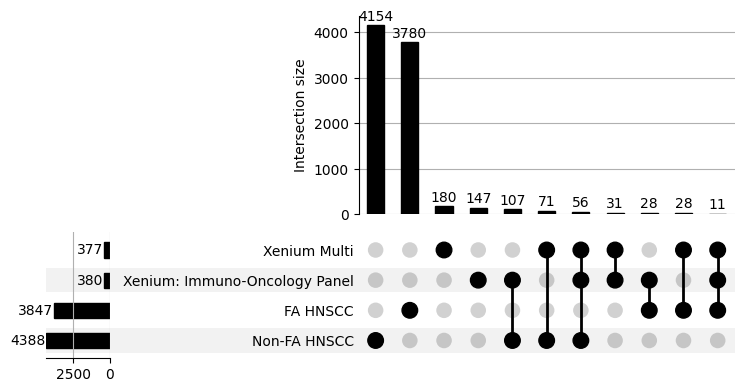

In [134]:
# Visualization of intersections using UpSet plot
contents = {
    'FA HNSCC': set(genes_fahnscc),
    'Non-FA HNSCC': set(genes_nonfahnscc),
    'Xenium Multi': set(genes_xenium_multi),
    'Xenium: Immuno-Oncology Panel': set(genes_xenium_immunoncology),
    #'Xenium Brain': set(genes_xenium_brain),
    #'Xenium Breast': set(genes_xenium_breast),
    #'Xenium Colon': set(genes_xenium_colon),
    #'Xenium Lung': set(genes_xenium_lung),
    #'Xenium Skin': set(genes_xenium_skin),
    #'Antibodies': set(genes_ab),
    #'Proteins CyCIF': set(proteins)
}
upset_data = from_contents(contents)
upset = UpSet(upset_data, subset_size='count', show_counts='%d', 
              sort_by='cardinality', sort_categories_by='cardinality')
plt.figure(figsize=(10, 10))
#plt.title("UpSet Plot of Gene Set Intersections")
upset.plot()
plt.savefig("upset_plot_panels.png", dpi=900, bbox_inches='tight')  # guarda el plot como PNG
plt.show()

In [142]:
# Detailed comparative analysis to help select the Xenium panel
# This code generates a complete report comparing Multi vs Immuno-Oncology vs other Xenium panels

output_path = "xenium_panel_comparison_for_experiment_design.txt"
with open(output_path, "w", encoding="utf-8") as out:
    out.write("=" * 80 + "\n")
    out.write("XENIUM PANELS COMPARISON FOR EXPERIMENT DESIGN\n")
    out.write("Analysis of FA-HNSCC and Non-FA HNSCC genes vs Xenium panels\n")
    out.write("=" * 80 + "\n\n")
    
    # Basic information about the sets
    out.write("BASIC INFORMATION ABOUT THE SETS:\n")
    out.write("-" * 40 + "\n")
    out.write(f"FA-HNSCC genes: {len(set1)} genes\n")
    out.write(f"Non-FA HNSCC genes: {len(set2)} genes\n")
    out.write(f"Xenium Multi panel: {len(set3)} genes\n")
    out.write(f"Xenium Immuno-Oncology panel: {len(set4)} genes\n")
    out.write(f"Xenium Brain panel: {len(set5)} genes\n")
    out.write(f"Xenium Breast panel: {len(set6)} genes\n")
    out.write(f"Xenium Colon panel: {len(set7)} genes\n")
    out.write(f"Xenium Lung panel: {len(set8)} genes\n")
    out.write(f"Xenium Skin panel: {len(set9)} genes\n\n")
    
    # ========== FA-HNSCC ANALYSIS ==========
    out.write("=" * 80 + "\n")
    out.write("1. DETAILED ANALYSIS: FA-HNSCC vs XENIUM PANELS\n")
    out.write("=" * 80 + "\n\n")
    
    # FA-HNSCC vs individual panels
    xenium_panels = {
        'Xenium Multi': set3,
        'Xenium Immuno-Oncology': set4,
        'Xenium Brain': set5,
        'Xenium Breast': set6,
        'Xenium Colon': set7,
        'Xenium Lung': set8,
        'Xenium Skin': set9
    }
    
    fa_results = {}
    for panel_name, panel_set in xenium_panels.items():
        intersection = set1.intersection(panel_set)
        fa_results[panel_name] = intersection
        out.write(f"FA-HNSCC ∩ {panel_name}:\n")
        out.write(f"  Number of genes: {len(intersection)}\n")
        out.write(f"  Coverage: {len(intersection)/len(set1)*100:.1f}% of FA-HNSCC genes\n")
        out.write(f"  Genes: {', '.join(sorted(intersection))}\n\n")
    
    # ========== NON-FA-HNSCC ANALYSIS ==========
    out.write("=" * 80 + "\n")
    out.write("2. DETAILED ANALYSIS: Non-FA HNSCC vs XENIUM PANELS\n")
    out.write("=" * 80 + "\n\n")
    
    nonfa_results = {}
    for panel_name, panel_set in xenium_panels.items():
        intersection = set2.intersection(panel_set)
        nonfa_results[panel_name] = intersection
        out.write(f"Non-FA HNSCC ∩ {panel_name}:\n")
        out.write(f"  Number of genes: {len(intersection)}\n")
        out.write(f"  Coverage: {len(intersection)/len(set2)*100:.1f}% of Non-FA HNSCC genes\n")
        out.write(f"  Genes: {', '.join(sorted(intersection))}\n\n")
    
    # ========== DIRECT COMPARISON: MULTI vs IMMUNO-ONCOLOGY ==========
    out.write("=" * 80 + "\n")
    out.write("3. DIRECT COMPARISON: MULTI vs IMMUNO-ONCOLOGY FOR YOUR EXPERIMENT\n")
    out.write("=" * 80 + "\n\n")
    
    # For FA-HNSCC
    fa_multi = fa_results['Xenium Multi']
    fa_io = fa_results['Xenium Immuno-Oncology']
    
    out.write("FOR FA-HNSCC GENES:\n")
    out.write("-" * 30 + "\n")
    out.write(f"Multi panel: {len(fa_multi)} genes ({len(fa_multi)/len(set1)*100:.1f}% coverage)\n")
    out.write(f"Immuno-Oncology panel: {len(fa_io)} genes ({len(fa_io)/len(set1)*100:.1f}% coverage)\n\n")
    
    # Unique genes for each panel for FA
    fa_only_multi = fa_multi - fa_io
    fa_only_io = fa_io - fa_multi
    fa_shared = fa_multi.intersection(fa_io)
    
    out.write(f"FA-HNSCC genes shared between both panels ({len(fa_shared)}):\n")
    out.write(f"  {', '.join(sorted(fa_shared))}\n\n")
    
    out.write(f"FA-HNSCC genes unique to the Multi panel ({len(fa_only_multi)}):\n")
    out.write(f"  {', '.join(sorted(fa_only_multi))}\n\n")
    
    out.write(f"FA-HNSCC genes unique to the Immuno-Oncology panel ({len(fa_only_io)}):\n")
    out.write(f"  {', '.join(sorted(fa_only_io))}\n\n")
    
    # For Non-FA-HNSCC
    nonfa_multi = nonfa_results['Xenium Multi']
    nonfa_io = nonfa_results['Xenium Immuno-Oncology']
    
    out.write("FOR Non-FA HNSCC GENES:\n")
    out.write("-" * 30 + "\n")
    out.write(f"Multi panel: {len(nonfa_multi)} genes ({len(nonfa_multi)/len(set2)*100:.1f}% coverage)\n")
    out.write(f"Immuno-Oncology panel: {len(nonfa_io)} genes ({len(nonfa_io)/len(set2)*100:.1f}% coverage)\n\n")
    
    # Unique genes for each panel for Non-FA
    nonfa_only_multi = nonfa_multi - nonfa_io
    nonfa_only_io = nonfa_io - nonfa_multi
    nonfa_shared = nonfa_multi.intersection(nonfa_io)
    
    out.write(f"Non-FA HNSCC genes shared between both panels ({len(nonfa_shared)}):\n")
    out.write(f"  {', '.join(sorted(nonfa_shared))}\n\n")
    
    out.write(f"Non-FA HNSCC genes unique to the Multi panel ({len(nonfa_only_multi)}):\n")
    out.write(f"  {', '.join(sorted(nonfa_only_multi))}\n\n")
    
    out.write(f"Non-FA HNSCC genes unique to the Immuno-Oncology panel ({len(nonfa_only_io)}):\n")
    out.write(f"  {', '.join(sorted(nonfa_only_io))}\n\n")
    
    # ========== RECOMMENDATION ==========
    out.write("=" * 80 + "\n")
    out.write("4. SUMMARY FOR DECISION MAKING\n")
    out.write("=" * 80 + "\n\n")
    
    total_fa_multi = len(fa_multi)
    total_fa_io = len(fa_io)
    total_nonfa_multi = len(nonfa_multi)
    total_nonfa_io = len(nonfa_io)
    
    out.write("TOTAL COVERAGE:\n")
    out.write("-" * 20 + "\n")
    out.write(f"Multi panel: {total_fa_multi} FA genes + {total_nonfa_multi} Non-FA genes = {total_fa_multi + total_nonfa_multi} total genes\n")
    out.write(f"Immuno-Oncology panel: {total_fa_io} FA genes + {total_nonfa_io} Non-FA genes = {total_fa_io + total_nonfa_io} total genes\n\n")
    
    out.write("CONSIDERATIONS FOR YOUR EXPERIMENT:\n")
    out.write("-" * 40 + "\n")
    if total_fa_multi + total_nonfa_multi > total_fa_io + total_nonfa_io:
        out.write("→ The MULTI panel has greater total coverage of your genes of interest\n")
    elif total_fa_io + total_nonfa_io > total_fa_multi + total_nonfa_multi:
        out.write("→ The IMMUNO-ONCOLOGY panel has greater total coverage of your genes of interest\n")
    else:
        out.write("→ Both panels have similar coverage of your genes of interest\n")
    
    out.write(f"→ Unique genes you would lose if you choose Multi: {len(fa_only_io) + len(nonfa_only_io)} genes\n")
    out.write(f"→ Unique genes you would lose if you choose Immuno-Oncology: {len(fa_only_multi) + len(nonfa_only_multi)} genes\n\n")

print(f"Detailed comparative analysis saved to: {output_path}")
print("This file will help you decide which Xenium panel to use for your experiment.")

Detailed comparative analysis saved to: xenium_panel_comparison_for_experiment_design.txt
This file will help you decide which Xenium panel to use for your experiment.


In [143]:
# Save exclusivity analysis to text file (English)

output_path = "FA_HNSCC_exclusivity_immuno_oncology.txt"
with open(output_path, "w", encoding="utf-8") as out:
    out.write("="*80 + "\n")
    out.write("EXCLUSIVITY ANALYSIS: FA-HNSCC GENES IN THE IMMUNO-ONCOLOGY PANEL\n")
    out.write("="*80 + "\n\n")
    
    out.write("QUESTION: Are the FA-HNSCC genes present in the Immuno-Oncology panel exclusive\n")
    out.write("or do they also appear in other Xenium panels (Multi, Brain, Breast, Colon, Lung, Skin)?\n\n")
    
    out.write("EXECUTIVE SUMMARY:\n")
    out.write("-"*20 + "\n")
    out.write(f"• Total FA-HNSCC genes in Immuno-Oncology panel: {len(fa_hnscc_in_immunoonc)}\n")
    out.write(f"• Genes that ARE UNIQUE to the IO panel: {len(fa_immunoonc_exclusivos)} ({len(fa_immunoonc_exclusivos)/len(fa_hnscc_in_immunoonc)*100:.1f}%)\n")
    out.write(f"• Genes that ALSO appear in other panels: {len(fa_immunoonc_en_otros)} ({len(fa_immunoonc_en_otros)/len(fa_hnscc_in_immunoonc)*100:.1f}%)\n\n")
    
    out.write("CONCLUSION:\n")
    if len(fa_immunoonc_exclusivos) > len(fa_immunoonc_en_otros):
        out.write("→ THE MAJORITY of FA-HNSCC genes in the IO panel are UNIQUE\n")
    elif len(fa_immunoonc_en_otros) > len(fa_immunoonc_exclusivos):
        out.write("→ THE MAJORITY of FA-HNSCC genes in the IO panel also appear in OTHER panels\n")
    else:
        out.write("→ There is a balance between unique and shared genes\n")
    out.write("\n" + "="*80 + "\n\n")
    
    out.write("FA-HNSCC GENES UNIQUE TO THE IMMUNO-ONCOLOGY PANEL:\n")
    out.write("(These genes DO NOT appear in any other Xenium panel)\n")
    out.write("-"*60 + "\n")
    if fa_immunoonc_exclusivos:
        for i, gene in enumerate(sorted(fa_immunoonc_exclusivos), 1):
            out.write(f"{i:2d}. {gene}\n")
    else:
        out.write("No unique genes found.\n")
    out.write(f"\nTotal: {len(fa_immunoonc_exclusivos)} unique genes\n\n")
    
    out.write("FA-HNSCC GENES ALSO FOUND IN OTHER PANELS:\n")
    out.write("(These genes are in the IO panel but also present in other panels)\n")
    out.write("-"*60 + "\n")
    if fa_immunoonc_en_otros:
        for gene in sorted(fa_immunoonc_en_otros):
            panels_with_gene = []
            for panel_name, panel_set in paneles_individuales.items():
                if gene in panel_set:
                    panels_with_gene.append(panel_name)
            out.write(f"• {gene}: also in → {', '.join(panels_with_gene)}\n")
    else:
        out.write("All genes are unique to the Immuno-Oncology panel.\n")
    out.write(f"\nTotal: {len(fa_immunoonc_en_otros)} shared genes\n\n")
    
    out.write("IMPLICATIONS FOR YOUR EXPERIMENT:\n")
    out.write("-"*40 + "\n")
    out.write("• If you choose the Immuno-Oncology panel, you will have access to FA-HNSCC genes\n")
    out.write("  that are not available in other Xenium panels\n")
    out.write(f"• Specifically, {len(fa_immunoonc_exclusivos)} FA-HNSCC genes would be exclusively\n")
    out.write("  accessible via the Immuno-Oncology panel\n")
    out.write(f"• The other {len(fa_immunoonc_en_otros)} FA-HNSCC genes in the IO panel could also\n")
    out.write("  be studied using alternative Xenium panels if needed\n")

print(f"Exclusivity analysis saved to: {output_path}")
print("This analysis helps you understand which FA-HNSCC genes are unique to the Immuno-Oncology panel.")

Exclusivity analysis saved to: FA_HNSCC_exclusivity_immuno_oncology.txt
This analysis helps you understand which FA-HNSCC genes are unique to the Immuno-Oncology panel.


In [144]:
# Save exclusivity analysis Non-FA HNSCC to text file

output_path = "NON_FA_HNSCC_exclusividad_immuno_oncology.txt"
with open(output_path, "w", encoding="utf-8") as out:
    out.write("="*80 + "\n")
    out.write("EXCLUSIVITY ANALYSIS: NON-FA HNSCC GENES IN IMMUNO-ONCOLOGY PANEL\n")
    out.write("="*80 + "\n\n")
    
    out.write("QUESTION: Are the Non-FA HNSCC genes in the Immuno-Oncology panel exclusive or do they also\n")
    out.write("appear in other Xenium panels (Multi, Brain, Breast, Colon, Lung, Skin)?\n\n")
    
    out.write("EXECUTIVE SUMMARY:\n")
    out.write("-"*20 + "\n")
    out.write(f"• Total Non-FA HNSCC genes in Immuno-Oncology panel: {len(nonfa_hnscc_in_immunoonc)}\n")
    out.write(f"• Genes that ARE EXCLUSIVE to the IO panel: {len(nonfa_immunoonc_exclusivos)} ({len(nonfa_immunoonc_exclusivos)/len(nonfa_hnscc_in_immunoonc)*100:.1f}%)\n")
    out.write(f"• Genes that ALSO appear in other panels: {len(nonfa_immunoonc_en_otros)} ({len(nonfa_immunoonc_en_otros)/len(nonfa_hnscc_in_immunoonc)*100:.1f}%)\n\n")
    
    out.write("CONCLUSION:\n")
    if len(nonfa_immunoonc_exclusivos) > len(nonfa_immunoonc_en_otros):
        out.write("→ THE MAJORITY of Non-FA HNSCC genes in the IO panel are EXCLUSIVE\n")
    elif len(nonfa_immunoonc_en_otros) > len(nonfa_immunoonc_exclusivos):
        out.write("→ THE MAJORITY of Non-FA HNSCC genes in the IO panel also appear in OTHER panels\n")
    else:
        out.write("→ There is a balance between exclusive and shared genes\n")
    out.write("\n" + "="*80 + "\n\n")
    
    out.write("NON-FA HNSCC GENES EXCLUSIVE TO THE IMMUNO-ONCOLOGY PANEL:\n")
    out.write("(These genes DO NOT appear in any other Xenium panel)\n")
    out.write("-"*60 + "\n")
    if nonfa_immunoonc_exclusivos:
        for i, gene in enumerate(sorted(nonfa_immunoonc_exclusivos), 1):
            out.write(f"{i:2d}. {gene}\n")
    else:
        out.write("No exclusive genes found.\n")
    out.write(f"\nTotal: {len(nonfa_immunoonc_exclusivos)} exclusive genes\n\n")
    
    out.write("NON-FA HNSCC GENES THAT ALSO APPEAR IN OTHER PANELS:\n")
    out.write("(These genes are in the IO panel but also in other panels)\n")
    out.write("-"*60 + "\n")
    if nonfa_immunoonc_en_otros:
        for gene in sorted(nonfa_immunoonc_en_otros):
            paneles_con_gen = []
            for panel_name, panel_set in paneles_individuales.items():
                if gene in panel_set:
                    paneles_con_gen.append(panel_name)
            out.write(f"• {gene}: also in → {', '.join(paneles_con_gen)}\n")
    else:
        out.write("All genes are exclusive to the Immuno-Oncology panel.\n")
    out.write(f"\nTotal: {len(nonfa_immunoonc_en_otros)} shared genes\n\n")
    
    out.write("COMPARISON WITH FA-HNSCC:\n")
    out.write("-"*30 + "\n")
    out.write(f"• FA-HNSCC genes exclusive to the IO panel: {len(fa_immunoonc_exclusivos)} genes\n")
    out.write(f"• Non-FA HNSCC genes exclusive to the IO panel: {len(nonfa_immunoonc_exclusivos)} genes\n")
    out.write(f"• FA-HNSCC genes shared with other panels: {len(fa_immunoonc_en_otros)} genes\n")
    out.write(f"• Non-FA HNSCC genes shared with other panels: {len(nonfa_immunoonc_en_otros)} genes\n\n")
    
    if len(nonfa_immunoonc_exclusivos) > len(fa_immunoonc_exclusivos):
        out.write("→ Non-FA HNSCC has MORE genes exclusive to the IO panel than FA-HNSCC\n")
    elif len(fa_immunoonc_exclusivos) > len(nonfa_immunoonc_exclusivos):
        out.write("→ FA-HNSCC has MORE genes exclusive to the IO panel than Non-FA HNSCC\n")
    else:
        out.write("→ FA-HNSCC and Non-FA HNSCC have a similar number of genes exclusive to the IO panel\n")
        
    out.write("\nIMPLICATIONS FOR YOUR EXPERIMENT:\n")
    out.write("-"*40 + "\n")
    out.write("• The Immuno-Oncology panel gives you access to unique Non-FA HNSCC genes\n")
    out.write(f"• Specifically, {len(nonfa_immunoonc_exclusivos)} Non-FA HNSCC genes would be exclusively\n")
    out.write("  accessible via the Immuno-Oncology panel\n")
    out.write(f"• The other {len(nonfa_immunoonc_en_otros)} Non-FA HNSCC genes in the IO panel could also\n")
    out.write("  be studied using other Xenium panels if needed\n")
    total_exclusivos = len(fa_immunoonc_exclusivos) + len(nonfa_immunoonc_exclusivos)
    out.write(f"\n• TOTAL unique genes of the IO panel (FA + Non-FA): {total_exclusivos} genes\n")
    out.write("• This represents a significant added value of the Immuno-Oncology panel\n")

print(f"Non-FA HNSCC exclusivity analysis saved to: {output_path}")
print(f"Generated files: FA_HNSCC_exclusividad_immuno_oncology.txt and {output_path}")

Non-FA HNSCC exclusivity analysis saved to: NON_FA_HNSCC_exclusividad_immuno_oncology.txt
Generated files: FA_HNSCC_exclusividad_immuno_oncology.txt and NON_FA_HNSCC_exclusividad_immuno_oncology.txt


## **Results:**
Based on the genes differentially expressed in both FA HNSCC tumors and Non-FA HNSCC tumors, together with the genes from the Xenium panels, an intersection analysis was performed in which we observed the following:

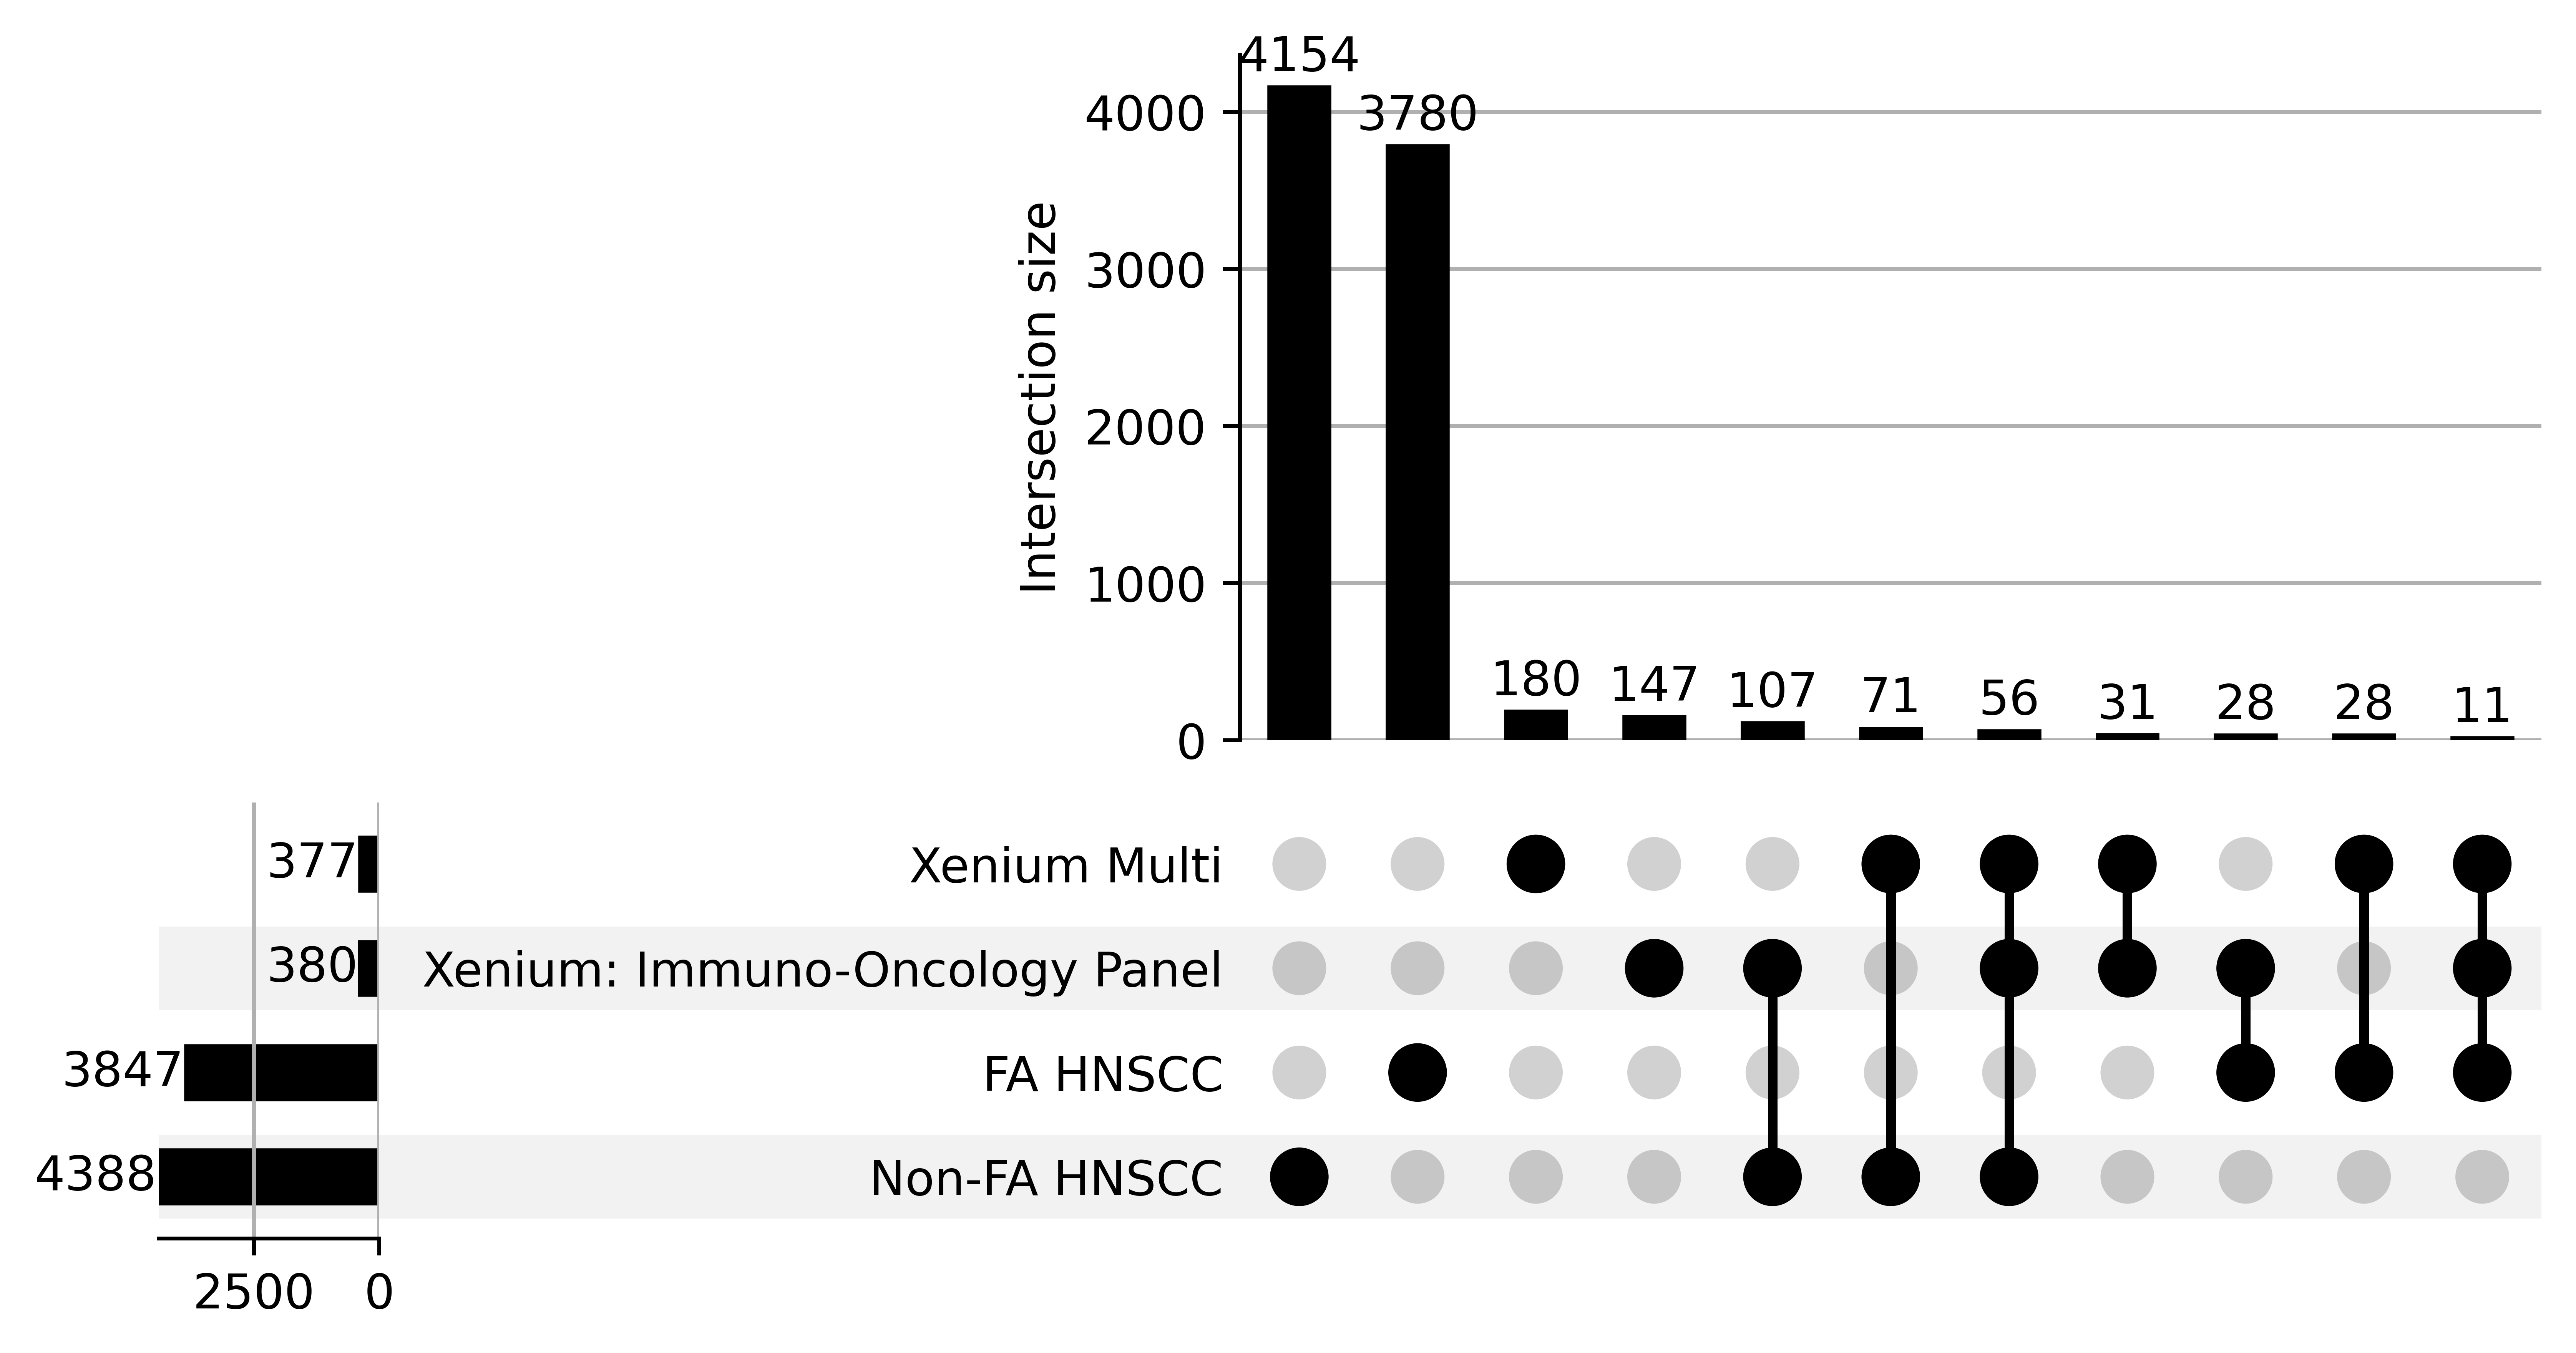

+ The differentially expressed genes in FA HNSCC share elements with the different Xenium panels as follows:

    | Intersection | Number of genes |
    |---|---:|
    | FA‑HNSCC ∩ Xenium Multi | 39 |
    | FA‑HNSCC ∩ Xenium Immuno‑Oncology | 39 |
    | FA‑HNSCC ∩ Xenium Brain | 35 |
    | FA‑HNSCC ∩ Xenium Breast | 35 |
    | FA‑HNSCC ∩ Xenium Colon | 32 |
    | FA‑HNSCC ∩ Xenium Lung | 29 |
    | FA‑HNSCC ∩ Xenium Skin | 25 |


The Xenium Human Multi-Tissue and Cancer Panel and the Xenium Human Immuno-Oncology Panel show the highest number of shared elements. In addition, the nature of this panel better matches the type of samples we have, from tumors of patients with FA. 

Although both panels share the same number of elements with the DEGs, they are not the same elements. **The genes in common are 11:**
    
> CD274, CDK1, CENPF, CXCL2, EGFR, FAS, IL7R, KLRD1, MET, MKI67, VCAN

The FA-HNSCC genes unique to the Multi-Tissue and Cancer panel are 28:
> ARFGEF3, ASPN, CAPN8, CCDC39, CD300E, COL5A2, CSF3, CYP3A4, DST, FBN1, GLIPR1, IGF1, LYVE1, MDM2, MLANA, NTN4, OGN, PPARG, PROX1, SLC18A2, SLC26A2, STC2, TFPI, TIMP4, TM4SF4, TMC5, TMEM100, TOP2A

The FA-HNSCC genes unique to the Immuno-Oncology panel are 28:
> AREG, ATM, BRAF, CCL16, CDK12, CDK6, CEACAM8, CXCL3, FGF2, HIF1A, IFIT2, IL10, IL13RA2, IL1A, IL1B, IL1R1, ITGA1, KMT2C, KRAS, MGP, MIS18BP1, NF1, NOTCH2, NT5E, ORC6, PIK3CA, PTEN, VEGFA

---

+ The differentially expressed genes in Non-FA HNSCC share elements with the different Xenium panels as follows:

    | Intersection | Number of genes |
    |---|---:|
    | Non-FA HNSCC ∩ Xenium Multi | 127 |
    | Non-FA HNSCC ∩ Xenium Immuno‑Oncology | 163 |
    | Non-FA HNSCC ∩ Xenium Brain | 66 |
    | Non-FA HNSCC ∩ Xenium Breast | 114 |
    | Non-FA HNSCC ∩ Xenium Colon | 116 |
    | Non-FA HNSCC ∩ Xenium Lung | 114 |
    | Non-FA HNSCC ∩ Xenium Skin | 93 |

Here the Xenium Human Immuno-Oncology Panel shows the largest intersection with the differentially expressed genes. 

In this case the number of elements in the intersections between the panels and the genes expressed in Non-FA HNSCC tumors is different; we can also observe a set of 56 commonly expressed genes:
  
  > AIF1, CCR7, CD14, CD19, CD1A, CD1C, CD2, CD247, CD27, CD3D, CD3E, CD4, CD68, CD79A, CD86, CD8A, CLEC10A, CPA3, CTLA4, CXCL10, CXCL9, CXCR4, DERL3, ERBB2, FCER1A, FCGR3A, FKBP11, FOXP3, GATA2, GNLY, GZMA, GZMB, GZMK, HAVCR2, HPGDS, IL2RA, IRF8, KLRB1, KLRC1, LAG3, LILRA4, LILRB4, MS4A1, MS4A2, MZB1, NKG7, PDCD1, PLA2G7, PLD4, PRF1, SELL, SOX17, SPIB, TCL1A, TNFRSF17, TREM2

The Non-FA-HNSCC genes unique to the Multi-Tissue and Cancer panel are 71:

  > ACKR1, ADGRE1, ADH1C, ADIPOQ, AMY2A, APOBEC3A, AQP3, ASCL1, BCL2L11, BTNL9, C1orf162, C1orf194, C20orf85, C6orf118, CAVIN1, CCL27, CD1E, CD34, CLCA2, CLEC14A, CLEC4E, CLECL1, CNN1, CSF2RA, CTSG, CYTIP, DES, DNASE1L3, ELF5, FOXJ1, GATM, GPC1, GPC3, GPX2, HAMP, HES4, HLA-DQB2, IGSF6, IL3RA, KLK11, KRT7, LGI4, LY6D, LY86, MALL, MMRN2, MS4A4A, MYBPC1, NPDC1, OPRPN, PCNA, PECAM1, PLAC9, PPP1R1A, PRDM1, PTGDS, RAMP2, RETN, S100A1, S100A12, SFRP4, SH2D3C, SLAMF1, SLAMF7, SOX18, SOX2, SPI1, TENT5C, THY1, TNFRSF13B, VWF

The FA-HNSCC genes unique to the Immuno-Oncology panel are 107:

  > ACTB, AKT1, ANXA1, APOE, ARID1A, C1QB, CCL11, CCL13, CCL2, CCL26, CCL3, CCL4, CCR4, CCR5, CD37, CD38, CD40, CD40LG, CD74, CD79B, CD8B, CDKN1A, CDKN2A, CDKN2C, CDKN2D, CEACAM6, CHIT1, CORO1A, CSF1R, CST7, CTSB, CTSD, CTSS, CTSW, CX3CR1, CXCL11, CXCL14, CXCL16, CXCR3, CXCR5, CXCR6, EGR3, FASLG, FCER2, FCGR2B, FCMR, FCRL3, FGR, FLT3LG, FOS, GPR171, GZMH, HLA-B, ICOSLG, IDO1, IL10RA, IL12B, IL15RA, IL22RA1, IL22RA2, IL2RB, IL2RG, IRF1, IRF2, IRF3, IRF5, ITGAE, JCHAIN, JUN, JUNB, KLRK1, LAMP1, LCK, LTB, LY6E, MMP12, MYD88, NELL2, NOTCH1, NOTCH3, P2RX1, PAX5, PLEK, PLVAP, PSMB10, RGS1, RORC, RUNX3, S100A9, S100B, SDC1, SMAD3, SOCS1, SOCS3, SPON2, SSR4, SYK, TBX21, TCF7, TFF3, TGFB1, TIGIT, TNFRSF1B, TP53, TRAT1, VSIR, ZNF683

---

**With the Immuno-Oncology panel we managed to capture a greater total number of genes:**

> Multi-Tissue and Cancer: 39 FA genes + 127 Non-FA genes = 166 total genes

> **Immuno-Oncology panel: 39 FA genes + 163 Non-FA genes = 202 total genes**

+ The FA HNSCC genes expressed in the Immuno-Oncology panel are 39:

    > AREG, ATM, BRAF, CCL16, CD274, CDK1, CDK12, CDK6, CEACAM8, CENPF, CXCL2, CXCL3, EGFR, FAS, FGF2, HIF1A, IFIT2, IL10, IL13RA2, IL1A, IL1B, IL1R1, IL7R, ITGA1, KLRD1, KMT2C, KRAS, MET, MGP, MIS18BP1, MKI67, NF1, NOTCH2, NT5E, ORC6, PIK3CA, PTEN, VCAN, VEGFA

---

+ Regarding the Immuno-Oncology panel, it shares 204 genes with the rest of the Xenium panels (Xenium Multi, Xenium Brain, Xenium Breast, Xenium Colon, Xenium Lung, Xenium Skin):

    > ACE2, ACTA2, ADAM28, AIF1, ANPEP, ANXA1, APOE, AREG, BANK1, C1QB, C1QBP, CCL19, CCL20, CCL4, CCL5, CCL8, CCND1, CCR2, CCR7, CD14, CD163, CD19, CD1A, CD1C, CD2, CD247, CD27, CD274, CD28, CD38, CD3D, CD3E, CD4, CD40, CD40LG, CD68, CD79A, CD79B, CD80, CD83, CD86, CD8A, CD8B, CDK1, CDK6, CDKN2B, CEACAM1, CEACAM6, CEACAM8, CENPF, CHIT1, CLEC10A, CLEC12A, CORO1A, COTL1, CPA3, CST7, CTLA4, CTSB, CTSL, CTSS, CTSW, CX3CR1, CXCL10, CXCL12, CXCL13, CXCL14, CXCL16, CXCL2, CXCL3, CXCL5, CXCL6, CXCL9, CXCR4, CXCR5, CXCR6, DCN, DERL3, DMBT1, DUSP2, EGFR, EPCAM, ERBB2, ERBB3, ESR1, FABP3, FAS, FASLG, FCER1A, FCER2, FCGR1A, FCGR3A, FCMR, FKBP11, FLT1, FOXP3, GATA2, GATA3, GLIPR2, GNLY, GPR171, GPR183, GPR34, GZMA, GZMB, GZMK, HAVCR2, HIF1A, HPGDS, ID2, ID4, IDO1, IFITM3, IGFBP7, IL1B, IL2RA, IL2RG, IL7R, IQGAP2, IRF4, IRF8, ITGAM, ITGAX, KIT, KLRB1, KLRC1, KLRD1, KLRF1, LAG3, LAMP3, LCK, LIF, LILRA4, LILRA5, LILRB2, LILRB4, LTB, LUM, MARCO, MCEMP1, MCEMP1, MET, MGP, MIS18BP1, MKI67, MMP12, MMP9, MPEG1, MS4A1, MS4A2, MZB1, NCAM1, NCEH1, NKG7, NOSIP, NOTCH1, NOTCH3, P2RX1, PAX5, PDCD1, PDCD1LG2, PDGFRA, PLA2G7, PLD4, PLVAP, PRDX4, PRF1, PTGS1, PTPRC, REG4, RGS1, RGS5, RNF43, RORC, RUNX3, S100B, SAMD3, SELL, SLC1A3, SOCS3, SOX17, SOX9, SPARCL1, SPIB, STAT3, STAT4, STMN1, SYK, TC2N, TCF7, TCL1A, TFF3, TGFB1, TIGIT, TMPRSS2, TNFRSF13C, TNFRSF17, TNFRSF9, TP53, TRAT1, TREM2, TUBB, UBE2C, VCAN, VSIG4

+ The panel-specific or unique genes of the Immuno-Oncology panel are 176:

    > A2M, ACTB, AIRE, AKT1, ARG1, ARID1A, ARPC3, ARPC5, ATM, BATF3, BCL2, BRAF, C1R, C1S, CCL11, CCL13, CCL14, CCL15, CCL16, CCL2, CCL21, CCL26, CCL28, CCL3, CCL3L1, CCL7, CCR1, CCR3, CCR4, CCR5, CCR6, CD276, CD37, CD44, CD47, CD74, CDK12, CDK2, CDK4, CDKN1A, CDKN1B, CDKN1C, CDKN2A, CDKN2C, CDKN2D, CDX1, CDX2, CENPV, CFC1, CMKLR1, CSF1, CSF1R, CTNNB1, CTSD, CXCL1, CXCL11, CXCR1, CXCR2, CXCR3, DGKA, EGF, EGR3, ENTPD1, EOMES, EPO, EPOR, ERBB4, FADD, FCGR2A, FCGR2B, FCRL3, FEZ1, FGF2, FGR, FHIT, FLT3LG, FN1, FOS, G0S2, GZMH, HLA-B, ICAM1, ICOSLG, ID1, IFIT2, IFIT3, IFNAR1, IFNB1, IFNGR1, IFNL1, IGHG1, IGHG2, IGHG3, IGHG4, IGHGP, IGHM, IGKC, IGLC3, IL10, IL10RA, IL12B, IL12RB2, IL13, IL13RA2, IL15, IL15RA, IL18, IL1A, IL1R1, IL1RAP, IL2, IL22RA1, IL22RA2, IL23A, IL2RB, IL4, IL4R, IL5, IL6, IRF1, IRF2, IRF3, IRF5, ISG15, ITGA1, ITGAE, JAK1, JAK2, JAK3, JCHAIN, JUN, JUNB, KLRK1, KMT2C, KRAS, LAMP1, LAMP2, LY6E, MUC5AC, MX1, MYD88, NELL2, NF1, NOD1, NOTCH2, NT5E, ORC6, PGA5, PIK3CA, PLEK, PSMB10, PTEN, RB1, S100A9, SDC1, SMAD3, SOCS1, SOCS2, SOS1, SPARC, SPON2, SSR4, STAT1, STAT2, STAT5B, STAT6, TBX21, TNF, TNFRSF1B, TOX, TUBA1B, TXLNA, VEGFA, VSIR, XBP1, ZNF683

---

+ Relationship between FA HNSCC genes and the Immuno-Oncology panel: of the 39 shared genes, 20 are exclusive to the panel and 19 are common with the rest of the Xenium panels.

    > Exclusive: ATM, BRAF, CCL16, CDK12, FGF2, IFIT2, IL10, IL13RA2, IL1A, IL1R1, ITGA1, KMT2C, KRAS, NF1, NOTCH2, NT5E, ORC6, PIK3CA, PTEN, VEGFA

    > Common: AREG, CD274, CDK1, CDK6, CEACAM8, CENPF, CXCL2, CXCL3, EGFR, FAS, HIF1A, IL1B, IL7R, KLRD1, MET, MGP, MIS18BP1, MKI67, VCAN

+ Relationship between the Non-FA HNSCC genes and the Immuno-Oncology panel: of the 163 shared genes, 60 are exclusive to the panel and 103 are common with the rest of the Xenium panels.

    > Exclusive: ACTB, AKT1, ARID1A, CCL11, CCL13, CCL2, CCL26, CCL3, CCR4, CCR5, CD37, CD74, CDKN1A, CDKN2A, CDKN2C, CDKN2D, CSF1R, CTSD, CXCL11, CXCR3, EGR3, FCGR2B, FCRL3, FGR, FLT3LG, FOS, GZMH, HLA-B, ICOSLG, IL10RA, IL12B, IL15RA, IL22RA1, IL22RA2, IL2RB, IRF1, IRF2, IRF3, IRF5, ITGAE, JCHAIN, JUN, JUNB, KLRK1, LAMP1, LY6E, MYD88, NELL2, PLEK, PSMB10, S100A9, SDC1, SMAD3, SOCS1, SPON2, SSR4, TBX21, TNFRSF1B, VSIR, ZNF683

    > Common: AIF1, ANXA1, APOE, C1QB, CCL4, CCR7, CD14, CD19, CD1A, CD1C, CD2, CD247, CD27, CD38, CD3D, CD3E, CD4, CD40, CD40LG, CD68, CD79A, CD79B, CD86, CD8A, CD8B, CEACAM6, CHIT1, CLEC10A, CORO1A, CPA3, CST7, CTLA4, CTSB, CTSS, CTSW, CX3CR1, CXCL10, CXCL14, CXCL16, CXCL9, CXCR4, CXCR5, CXCR6, DERL3, ERBB2, FASLG, FCER1A, FCER2, FCGR3A, FCMR, FKBP11, FOXP3, GATA2, GNLY, GPR171, GZMA, GZMB, GZMK, HAVCR2, HPGDS, IDO1, IL2RA, IL2RG, IRF8, KLRB1, KLRC1, LAG3, LCK, LILRA4, LILRB4, LTB, MMP12, MS4A1, MS4A2, MZB1, NKG7, NOTCH1, NOTCH3, P2RX1, PAX5, PDCD1, PLA2G7, PLD4, PLVAP, PRF1, RGS1, RORC, RUNX3, S100B, SELL, SOCS3, SOX17, SPIB, SYK, TCF7, TCL1A, TFF3, TGFB1, TIGIT, TNFRSF17, TP53, TRAT1, TREM2

**In total, of the genes in the Xenium Immuno-Oncology panel, a total of 80 genes are exclusive to our comparison between HNSCC tumors with and without FA.**

Session Info:

In [145]:
# Información de la sesión
!python --version

Python 3.12.1


In [146]:
!pip list

Package                   Version
------------------------- ---------
adjustText                1.0.4
asttokens                 2.4.1
attrs                     25.3.0
certifi                   2025.4.26
charset-normalizer        3.4.2
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.0
cycler                    0.12.1
debugpy                   1.8.2
decorator                 5.1.1
docopt                    0.6.2
et_xmlfile                2.0.0
executing                 2.0.1
fastjsonschema            2.21.1
fonttools                 4.47.2
ftpretty                  0.4.0
goatools                  1.4.12
gseapy                    1.1.8
idna                      3.10
ipykernel                 6.29.5
ipython                   8.26.0
jedi                      0.19.1
joblib                    1.4.2
jsonschema                4.23.0
jsonschema-specifications 2025.4.1
jupyter_client            8.6.2
jupyter_core              5.7.2
kiwisolver         


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
